# RA model using the whole CV with automatic dataset


In [122]:
#Import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Activation, Dense, LeakyReLU
from sklearn.model_selection import KFold
from sklearn import preprocessing

In [123]:
x = np.load('np_dataset-Copy1.npz')['a']
labels = np.load('np_labels-Copy1.npz')['a'].astype(float)

#Only using the CVs here. 
CVs = x[:,0,:] #returns a numpy array 1->cv 2-> BKG current



#Normalization of features BUT NOT THE LABELS. 
#returns a numpy array
standard_scaler = preprocessing.StandardScaler()
CVs_scaled = standard_scaler.fit_transform(CVs)
dataset = np.zeros((len(labels), CVs_scaled.shape[1] + 1)) 
dataset[:,0:CVs_scaled.shape[1]] = CVs_scaled
dataset [:, CVs_scaled.shape[1]] = labels
dataset = pd.DataFrame(dataset)

In [124]:
from sklearn.model_selection import train_test_split
CVs_train, CVs_test, lab_train,lab_test = train_test_split(CVs_scaled, labels, shuffle = True, test_size = 0.20, random_state = 1)

In [125]:
#Define the model. Important: it needs to be the same structure as in tensorflow.js 
    
def build_and_compile_model():
    model = keras.Sequential([
    layers.Dense(1100, activation='relu', input_shape=[1100,]),
    layers.Dense(550, activation='selu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [126]:
#Define a function to plot the loss per epoch 
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Concentration]')
    plt.legend()
    plt.grid(True)
    plt.figure()
    plt.plot(history.history['root_mean_squared_error'], label="rmse")
    plt.plot(history.history['root_mean_squared_error'], label="rmse")
    plt.xlabel('Epoch')
    plt.ylabel('RMSE [Concentration]')

In [127]:
##Define a function to plot the prediction 
def plot_prediction(x, y):
    plt.scatter(train_features['Charge'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Charge')
    plt.ylabel('Concentration')
    plt.legend()

In [128]:
#Shuffling the whole dataset. 
dataset = dataset.sample(frac=1).reset_index(drop=True)

RMSE: 
4.027052586836938
RMSE: 
4.6227733372185975
RMSE: 
3.8001696316411913
RMSE: 
5.966359777229005
RMSE: 
77.67073855619944


<Figure size 432x288 with 0 Axes>

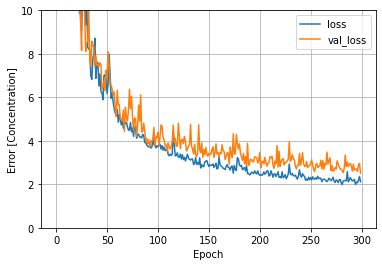

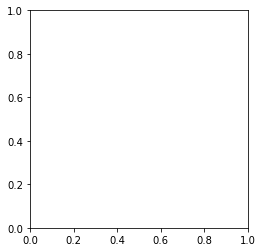

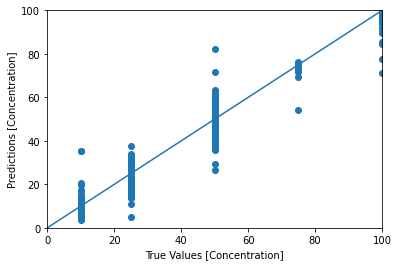

<Figure size 432x288 with 0 Axes>

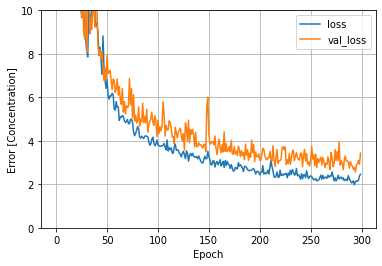

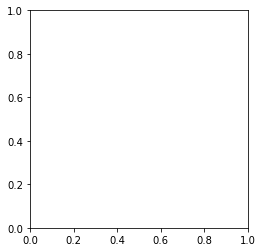

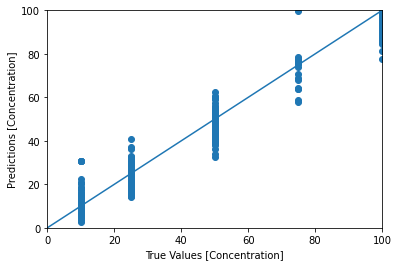

<Figure size 432x288 with 0 Axes>

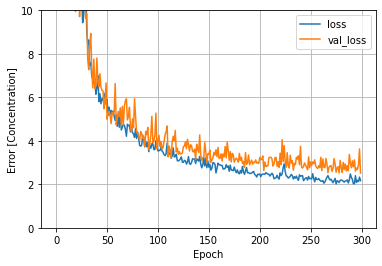

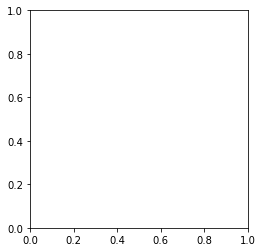

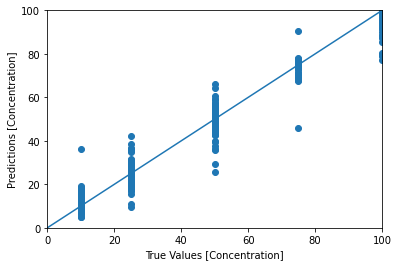

<Figure size 432x288 with 0 Axes>

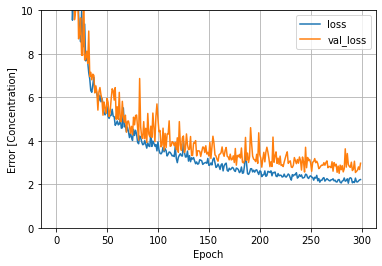

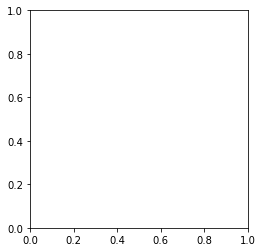

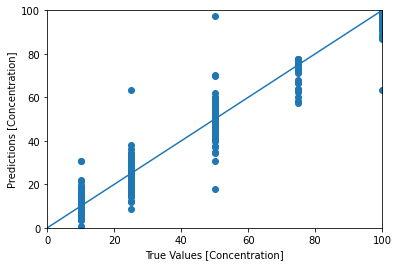

<Figure size 432x288 with 0 Axes>

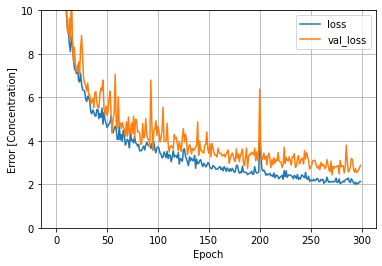

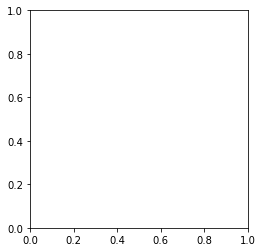

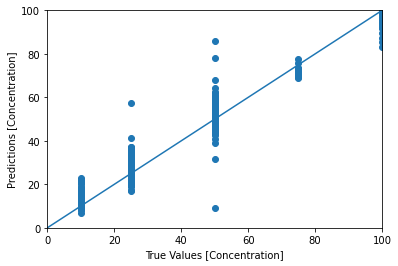

In [129]:
# Merge inputs and targets
#inputs = dataset.copy()
#targets = np.array(inputs.pop(1100).values)
#inputs = np.array(inputs.values)

inputs = CVs_train
targets = lab_train

# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    mod = build_and_compile_model()
    #dnn_fscav.summary()
    #Train the model
    history = mod.fit(
    inputs[train], targets[train],                         # changed expression for test features and labels
    validation_split=0.25,                                 # I removed validation for k-fold cross validation
    verbose=0, epochs=300)
    newfig = plt.figure()
    plot_loss(history)
    #Prediction of the validation dataset 
    test_predictions = mod.predict(inputs[test]).flatten()

    a = plt.axes(aspect='equal')
    newfig2 = plt.figure()
    plt.scatter(targets[test], test_predictions)
    plt.xlabel('True Values [Concentration]')
    plt.ylabel('Predictions [Concentration]')
    lims = [0,100]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    print('RMSE: ')
    print(math.sqrt(tf.keras.losses.MSE(test_predictions, targets[test])))
    fold_no = fold_no + 1

In [130]:
from sklearn.metrics import mean_squared_error
# Error on test dataset
testinputs = CVs_test
#print(testinputs.shape)
testtargets = lab_test
#print(targets)
bkgpred = mod.predict(testinputs)
errreal = mean_squared_error(testtargets, bkgpred)
print('Our error values is:', errreal)

Our error values is: 15.63135735236121


In [131]:
# Now we put random values (0-1) to each input for let's say 100 times an calculate mean error on testtargets changing that input. The bigger the error the more important is that input
import random
import time
randsample = 100
random.seed(98)
permutsample = np.zeros((randsample, testinputs.shape[0]))
for trying in range(randsample):
    start_time = time.time()
    randval = np.zeros((testinputs.shape[0]))
    for i in range(testinputs.shape[0]):
        randval[i] = random.uniform(-1,1) #stand dev 1

    for i in range(testinputs.shape[1]):
        permutinput = np.zeros(np.shape(testinputs))
        permutinput[:] = testinputs
        permutinput[:,i] = randval
        bkgpred = mod.predict(permutinput)
        #print('Done')
        err = mean_squared_error(testtargets, bkgpred)
        permutsample[trying, i] = err
    print(time.time()-start_time)
    print(trying)
#print permutsample
#print testparamnormOh 

199.6949417591095
0
200.18976616859436
1
199.92803382873535
2
200.43399095535278
3
200.9183292388916
4


KeyboardInterrupt: 

In [ ]:
#print mean and standard deviation of error
errperformance = np.zeros((testinputs.shape[1], 2))
for i in range(testinputs.shape[1]):
    errperformance[i,0] = np.mean(permutsample[:,i])
    errperformance[i,1] = np.std(permutsample[:,i])
errperformance[:,0] = abs(errreal - errperformance[:,0])

plt.errorbar(np.arange(testinputs.shape[1]), errperformance[:,0], errperformance[:,1])

In [ ]:
fig,ax = plt.subplots(figsize = (20,10))

for pos, y , err in zip(np.arange(testinputs.shape[1])[::7], errperformance[::7,0], errperformance[::7,1]):
    if err > np.mean(errperformance[::10,1]):
        ecolor_ = 'blue'
    else:
        ecolor_ = 'lightblue'
    ax.errorbar(pos,y,err,fmt = 'o', color = 'black', ecolor = ecolor_ , capsize = 3, elinewidth = 3)
    
from scipy.interpolate import BSpline
from scipy import interpolate

x_new = np.linspace(0,testinputs.shape[1], 500)
a_BSpline = interpolate.make_interp_spline(np.arange(testinputs.shape[1])[:], errperformance[:,0],2)
y_new = a_BSpline(x_new)
ax.plot(x_new[:(len(x_new)-4)], y_new[:(len(y_new)-4)], linewidth = 2, color = 'lightgrey', alpha = 0.3)

In [ ]:
pd.DataFrame(permutsample).to_excel('error10.xlsx')